In [47]:
import torch
from botorch.models import SingleTaskGP, MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import MultitaskGaussianLikelihood

from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel, LinearKernel
from gpytorch.kernels import ProductKernel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
def multi_task_gp(x_sim, y_sim, x_train, y_train):
    # Define the kernels for simulation and experimental data
    sim_kernel = ScaleKernel(MaternKernel())

    x_sim_task = torch.cat([torch.zeros((x_sim.shape[0], 1)), x_sim], dim=1)
    x_train_task = torch.cat([torch.ones((x_train.shape[0], 1)), x_train], dim=1)

    # Create the multi-task GP model
    model = MultiTaskGP(
        torch.cat([x_sim_task, x_train_task], dim=0), 
        torch.cat([y_sim, y_train], dim=0),
        task_feature=0,  # Specify the task feature index
        covar_module= sim_kernel # ScaleKernel(RBFKernel())
    )

    # Fit the model
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    return model

In [50]:
def multi_input_task_gp(x_sim_1, x_sim_2, y_sim, x_train_1, x_train_2, y_train):
    # Define the kernels for simulation and experimental data
    x_sim = torch.cat([x_sim_1, x_sim_2], dim=1)
    x_train = torch.cat([x_train_1, x_train_2], dim=1)
    
    sim_kernel = ScaleKernel(MaternKernel())

    x_sim_task = torch.cat([torch.zeros((x_sim.shape[0], 1)), x_sim], dim=1)
    x_train_task = torch.cat([torch.ones((x_train.shape[0], 1)), x_train], dim=1)

    # Create the multi-task GP model
    model = MultiTaskGP(
        torch.cat([x_sim_task, x_train_task], dim=0), 
        torch.cat([y_sim, y_train], dim=0),
        task_feature=0,  # Specify the task feature index
        covar_module= ScaleKernel(RBFKernel())
    )

    # Fit the model
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    return model

# Load and visuzalize the data

In [51]:
path_to_sim_data = '../../simulation_data/simulation_data.csv'
path_to_exp_data = '../../experimental_data/experimental_data.csv'

In [52]:
df_sim = pd.read_csv(path_to_sim_data)
df_exp = pd.read_csv(path_to_exp_data)

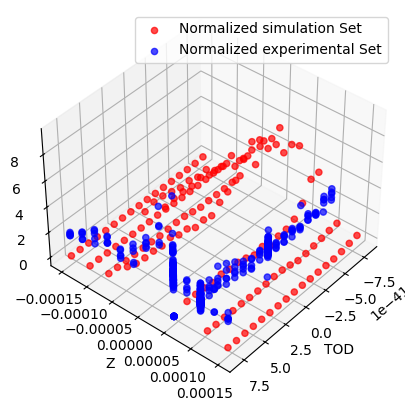

In [53]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter( df_sim['TOD (s^3)'], df_sim['z_target (m)'],
           df_sim['n_protons (1/sr)'], c='r', alpha=0.7, label='Normalized simulation Set')
ax.scatter( df_exp['TOD (s^3)'], df_exp['z_target (m)'],
           df_exp['n_protons (1/sr)'], c='b', alpha=0.7, label='Normalized experimental Set')
ax.view_init(elev=40., azim=40, roll=0)
# Set labels and title
ax.set_xlabel('TOD')
ax.set_ylabel('Z')
ax.set_zlabel('Protons')

# Add legend
ax.legend()
# Show plot
plt.show()

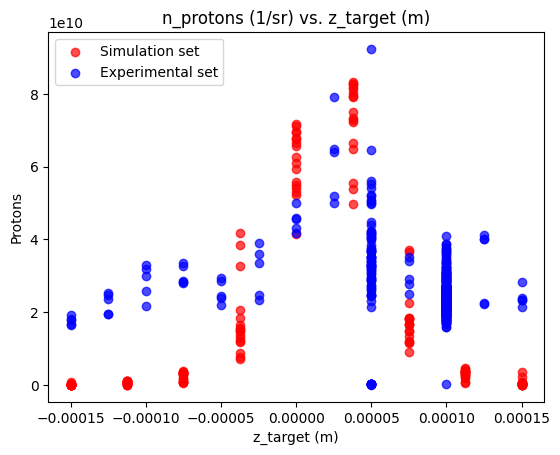

In [54]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter( df_sim['z_target (m)'],
           df_sim['n_protons (1/sr)'], c='r', alpha=0.7, label='Simulation set')
ax.scatter(  df_exp['z_target (m)'],
           df_exp['n_protons (1/sr)'], c='b', alpha=0.7, label='Experimental set')
ax.set_title('n_protons (1/sr) vs. z_target (m)')
# Set labels and title
ax.set_xlabel('z_target (m)')
ax.set_ylabel('Protons')

# Add legend
ax.legend()
# Show plot
plt.show()

# Normalization of the data sets

In [55]:
from botorch.models.transforms.input import AffineInputTransform

In [56]:
# Define the input and output normalizations, based on the training set
X = torch.tensor(df_sim[['z_target (m)', 'TOD (s^3)']].values, dtype=torch.float)
input_transform = AffineInputTransform(2, coefficient=X.std(axis=0), offset=X.mean(axis=0))
y = torch.tensor(df_sim['n_protons (1/sr)'].values, dtype=torch.float).reshape(-1,1)
output_transform = AffineInputTransform( 1, coefficient=y.std(axis=0), offset=y.mean(axis=0))

In [57]:
norm_sim_data = df_sim.copy()
norm_sim_data[['z_target (m)', 'TOD (s^3)']] = input_transform( torch.tensor( df_sim[['z_target (m)', 'TOD (s^3)']].values ) )
norm_sim_data[['n_protons (1/sr)']] = output_transform( torch.tensor( df_sim[['n_protons (1/sr)']].values.reshape(-1,1) ) )

norm_exp_data = df_exp.copy()
norm_exp_data[['z_target (m)', 'TOD (s^3)']] = input_transform( torch.tensor( df_exp[['z_target (m)', 'TOD (s^3)']].values ) )
norm_exp_data[['n_protons (1/sr)']] = output_transform( torch.tensor( df_exp[['n_protons (1/sr)']].values.reshape(-1,1) ) )

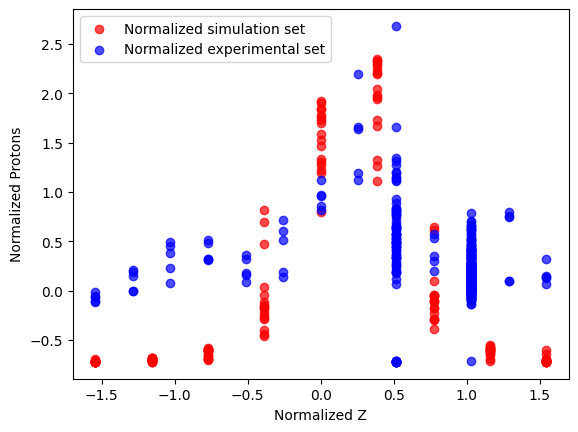

In [58]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter( norm_sim_data['z_target (m)'],
           norm_sim_data['n_protons (1/sr)'], c='r', alpha=0.7, label='Normalized simulation set')
ax.scatter(  norm_exp_data['z_target (m)'],
           norm_exp_data['n_protons (1/sr)'], c='b', alpha=0.7, label='Normalized experimental set')
# Set labels and title
ax.set_xlabel('Normalized Z')
ax.set_ylabel('Normalized Protons')


# Add legend
ax.legend()
# Show plot
plt.show()

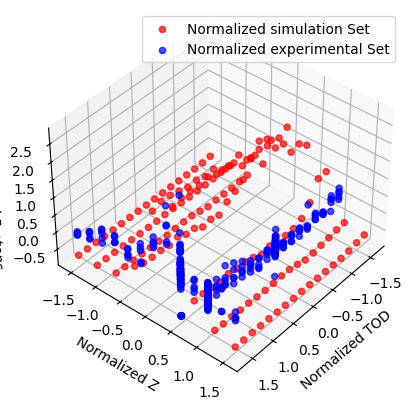

In [59]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter( norm_sim_data['TOD (s^3)'], norm_sim_data['z_target (m)'],
           norm_sim_data['n_protons (1/sr)'], c='r', alpha=0.7, label='Normalized simulation Set')
ax.scatter( norm_exp_data['TOD (s^3)'], norm_exp_data['z_target (m)'],
           norm_exp_data['n_protons (1/sr)'], c='b', alpha=0.7, label='Normalized experimental Set')
ax.view_init(elev=40., azim=40, roll=0)
# Set labels and title
ax.set_xlabel('Normalized TOD')
ax.set_ylabel('Normalized Z')
ax.set_zlabel('Normalized Protons')

# Add legend
ax.legend()
# Show plot
plt.show()

# Spliting normalized experimental data set

In [60]:
spliting_z_target = 0.1

norm_exp_test = norm_exp_data.loc[norm_exp_data['z_target (m)'] < spliting_z_target]
norm_exp_training = norm_exp_data.loc[norm_exp_data['z_target (m)'] >= spliting_z_target]

# (1) Predictin of n_protons with input feature: z_target

In [61]:
z_sim = torch.tensor(norm_sim_data[['z_target (m)']].values)
TOD_sim = torch.tensor(norm_sim_data[['TOD (s^3)']].values)
protons_sim = torch.tensor(norm_sim_data[['n_protons (1/sr)']].values)

z_exp_tr = torch.tensor(norm_exp_training[['z_target (m)']].values)
TOD_exp_tr = torch.tensor(norm_exp_training[['TOD (s^3)']].values)
protons_exp_tr = torch.tensor(norm_exp_training[['n_protons (1/sr)']].values)


z_exp_test = torch.tensor(norm_exp_test[['z_target (m)']].values)
TOD_exp_test = torch.tensor(norm_exp_test[['TOD (s^3)']].values)
protons_exp_test = torch.tensor(norm_exp_test[['n_protons (1/sr)']].values)

z_test_array = torch.tensor (np.arange(-1.5,1.5,0.01).reshape(-1, 1), dtype=torch.float32) 

In [64]:
model = multi_task_gp(z_sim, protons_sim, z_exp_tr, protons_exp_tr)
predictions_on_test = model.posterior(z_exp_test)
predictions_on_train = model.posterior(z_exp_tr)

predictions = model.posterior( z_test_array )
lower_bound = predictions.confidence_region()[1].detach().numpy()[:,0]
upper_bound = predictions.confidence_region()[1].detach().numpy()[:,1]

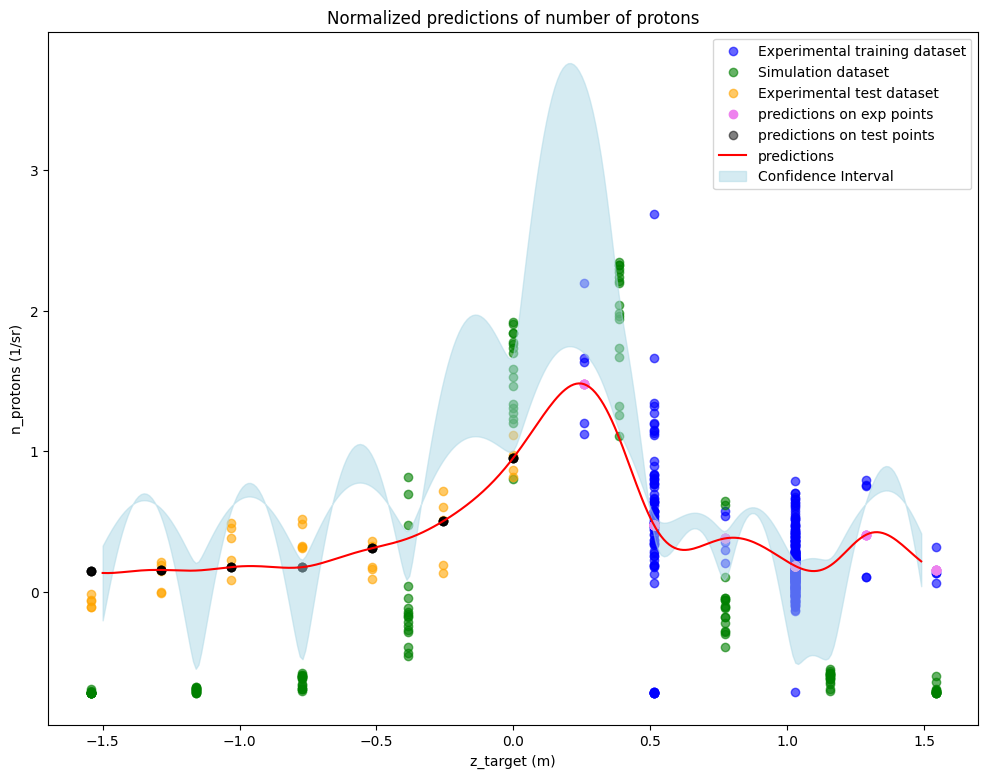

In [65]:
fig, ax = plt.subplots(figsize=(12,9))

ax.scatter(z_exp_tr, protons_exp_tr, label='Experimental training dataset', alpha=0.6, color = 'blue')
ax.scatter(z_sim, protons_sim, label='Simulation dataset', alpha=0.6, color = 'green')
ax.scatter(z_exp_test, protons_exp_test, label='Experimental test dataset', alpha=0.6, color='orange')
ax.scatter(z_exp_tr, predictions_on_train.mean[:,1].detach().numpy(), label='predictions on exp points', color='violet')
ax.scatter(z_exp_test, predictions_on_test.mean[:,1].detach().numpy(), alpha=0.5, color='black', label='predictions on test points')
plt.plot(z_test_array.numpy(),predictions.mean[:,1].detach().numpy(), label='predictions', c='r' )

plt.fill_between(z_test_array.numpy().flatten(), lower_bound, upper_bound, color='lightblue', alpha=0.5, label='Confidence Interval')


plt.title("Normalized predictions of number of protons")
plt.xlabel('z_target (m)')
plt.ylabel('n_protons (1/sr)')
plt.savefig('./' + 'n_protons_predictions_split_zval__' + str(spliting_z_target)+ '.png')
plt.legend()

# (2) Predictin of n_protons with input features: {z_target, TOD}

In [66]:
model2 = multi_input_task_gp(z_sim, TOD_sim, protons_sim, z_exp_tr, TOD_exp_tr, protons_exp_tr)

z_test_array = torch.tensor (np.linspace(-1.5,1.5,100).reshape(-1, 1), dtype=torch.float32) 
TOD_test_array  = torch.tensor (np.linspace(-1.63,1.63,100).reshape(-1, 1), dtype=torch.float32) 

predictions_on_train = model2.posterior(torch.cat([z_exp_tr, TOD_exp_tr], dim=1) )
predictions_on_test = model2.posterior(torch.cat([z_exp_test, TOD_exp_test], dim=1))

predictions = model2.posterior( torch.cat([z_test_array, TOD_test_array], dim=1) )
lower_bound = predictions.confidence_region()[1].detach().numpy()[:,0]
upper_bound = predictions.confidence_region()[1].detach().numpy()[:,1]

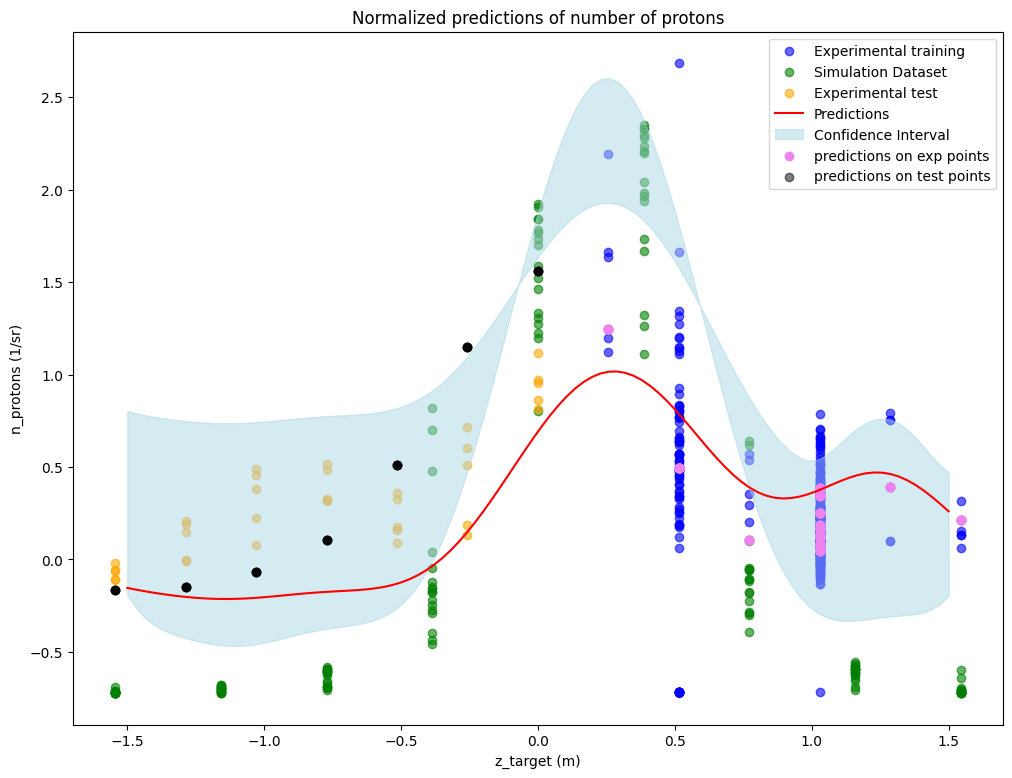

In [69]:
fig, ax = plt.subplots(figsize=(12,9))

ax.scatter(z_exp_tr, protons_exp_tr, label='Experimental training', alpha=0.6, color = 'blue')
ax.scatter(z_sim, protons_sim, label='Simulation Dataset', alpha=0.6, color = 'green')
ax.scatter(z_exp_test, protons_exp_test, label='Experimental test', alpha=0.6, color='orange')

plt.plot(z_test_array.numpy(),predictions.mean[:,1].detach().numpy(), label='Predictions', c='r' )
plt.fill_between(z_test_array.numpy().flatten(), lower_bound, upper_bound, color='lightblue', alpha=0.5, label='Confidence Interval')

ax.scatter(z_exp_tr, predictions_on_train.mean[:,1].detach().numpy(), label='predictions on exp points', color='violet')
ax.scatter(z_exp_test, predictions_on_test.mean[:,1].detach().numpy(), alpha=0.5, color='black', label='predictions on test points')

plt.title("Normalized predictions of number of protons")
plt.xlabel('z_target (m)')
plt.ylabel('n_protons (1/sr)')
plt.savefig('./' + 'n_protons_predictions_split_zval__' + str(spliting_z_target)+ '.png')
plt.legend()